In this notebook, I train a transformer model on the news-commentary-v16 dataset. The main purpose of this notebook is to study how the performance of the model changes as training set size increases. The result is shown in the plots at the end of this notebook.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/ML/Transformers
# !ls

In [ ]:
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet

     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 90 kB 4.2 MB/s 


In [ ]:
import math
from dataclasses import dataclass

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import json
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
SRC = "zh"
TRG = "en"
en_vocab_size = 30000
zh_vocab_size = 30000
vocab_sizes = {"en": en_vocab_size, "zh": zh_vocab_size}
max_seq_len = 50

# Get English and Chinese tokenizers

I use [SentencePiece](https://github.com/google/sentencepiece) to get both the Chinese and English tokenizers. 

The news-commentary-v16 dataset can be downloaded from https://data.statmt.org/news-commentary/v16/training/.

The validation set and test set I used are simply sampled from the news-commentary-v16 dataset, both with a size of 5000.


In [ ]:
full_set = pandas.read_csv('data/news-commentary-v16.en-zh.tsv',
                           sep='\t', header=None)
full_set = [(full_set[0][i], full_set[1][i]) for i in range(len(full_set[0]))
          if not isinstance(full_set[0][i], float) and not isinstance(full_set[1][i], float)]
random.shuffle(full_set)
# Note that some translations are really bad, and somehow news-commentary-v16 seems to 
# be one of the popular (small) training set...
full_train_set, valid_set, test_set= torch.utils.data.random_split(
                                        full_set, [len(full_set)-10000, 5000, 5000],
                                        generator=torch.Generator().manual_seed(42))
print(len(full_train_set), len(valid_set), len(test_set))
for i in range(3):
    print(full_train_set[i])

303674 5000 5000
('Coming into office, Rouhani had a clear priority: fix an economy devastated by eight years of former President Mahmoud Ahmadinejad’s demagogic mismanagement.', '鲁哈尼是带着明确的当务之急上台的：修复被前总统内贾德蛊惑人心的八年乱政摧毁的经济。')
('The Eurozone is Still Vulnerable', '欧元区仍然脆弱')
('The Middle East’s Arc of Prosperity', '中东的繁荣之弧')


In [ ]:
def get_tokenizers(dataset, train_set_size):
    en_file = f'data/zh-en_corpus_en_trainsize_{train_set_size}.txt'
    zh_file = f'data/zh-en_corpus_zh_trainsize_{train_set_size}.txt'
    en_sp_model = f'zh-en_en_trainsize_{train_set_size}'
    zh_sp_model = f'zh-en_zh_trainsize_{train_set_size}'
    f_en = open(en_file, "w")
    f_zh = open(zh_file, "w")
    for pair in list(dataset)[0:train_set_size]:
        f_en.write(pair[0] + '\n')
        f_zh.write(pair[1] + '\n')
    f_en.close()
    f_zh.close()
    # train sentencepiece models to get tokenizers
    spm.SentencePieceTrainer.train\
        (f'--input={en_file} --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size={en_vocab_size}')
    spm.SentencePieceTrainer.train\
        (f'--input={zh_file} --model_prefix=zh_sp_model --user_defined_symbols=<pad> --vocab_size={zh_vocab_size}')

    # make SentencePieceProcessor instances and load the model files
    en_sp = spm.SentencePieceProcessor()
    en_sp.load(f'en_sp_model.model')
    zh_sp = spm.SentencePieceProcessor()
    zh_sp.load(f'zh_sp_model.model')

    tokenizers = {"en": en_sp.encode_as_ids, "zh": zh_sp.encode_as_ids}
    detokenizers = {"en":en_sp.decode_ids, "zh":zh_sp.decode_ids}
    id_to_pieces = {"en":en_sp.id_to_piece, "zh":zh_sp.id_to_piece}
    return tokenizers, detokenizers, id_to_pieces

In [ ]:
tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, 50000)
print(tokenizers['zh']('这是一个测试。'))
print(tokenizers['en']('This is a test.'))
print([id_to_pieces['zh'](id) for id in range(20)])
print([id_to_pieces['en'](id) for id in range(20)])

[3766, 2061, 5]
[96, 14, 11, 1527, 6]
['<unk>', '<s>', '</s>', '<pad>', ',', '。', '▁', '的', '▁—', '和', '、', '在', '(', '是', '“', ')', '了', '年', '对', '将']
['<unk>', '<s>', '</s>', '<pad>', ',', '▁the', '.', '▁to', '▁of', '▁and', '▁in', '▁a', 's', '▁that', '▁is', '-', '’', '▁', '▁for', 'ing']


In [ ]:
# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3

# Data processing

In [ ]:
def tokenize_dataset(dataset):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    if SRC == "zh":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]


In [ ]:
class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded


In [ ]:
batch_size = 128

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self, train_set_size):
        train_set = list(full_train_set)[0:train_set_size]
        train_dataset = TranslationDataset(tokenize_dataset(train_set))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)


# Transformer Model

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_embed)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
  '''residual connection: x + dropout(sublayer(layernorm(x))) '''
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))

# I simply let the model learn the positional embeddings in this notebook, since this 
# almost produces identital results as using sin/cosin functions embeddings, as claimed
# in the original transformer paper. Note also that in the original paper, they multiplied 
# the token embeddings by a factor of sqrt(d_embed), which I do not do here. 

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [ ]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

# Training and evaluation helper functions

In [ ]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [ ]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y)  in  pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        # report progress
        if idx>0 and idx%50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')
    return np.mean(losses)


def train(model, dataloaders, epochs = 10):
    global early_stop_count
    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader)*batch_size
    for ep in range(epochs):
        train_loss = train_epoch(model, dataloaders)
        valid_loss = validate(model, dataloaders.valid_loader)

        print(f'ep: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
        else:
            if scheduler.last_epoch>1.5*warmup_steps:
                early_stop_count -= 1
                if early_stop_count<=0:
                    return train_loss, valid_loss
    return train_loss, valid_loss


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses += (loss_fn(pred, trg_out).item())
    return losses/len(dataloder)

In [ ]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

In [ ]:
def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

# Training

In [ ]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     d_ff=2048,
                     h=8,
                     N_encoder=6,
                     N_decoder=6,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )
results = {}
for train_size in  np.array([5, 10, 15, 20, 25, 30])*10000:
    tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, train_size)
    data_loaders = Dataloaders(train_size)
    model = make_model(config)
    model_size = sum([p.numel() for p in model.parameters()])
    print(f'model_size: {model_size}, train_set_size: {train_size}')
    warmup_steps = 3*len(data_loaders.train_loader)
    # lr first increases in the warmup steps, and then descreases
    lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
    optimizer = torch.optim.Adam(model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    early_stop_count = 2
    train_loss, valid_loss = train(model, data_loaders, epochs=30)
    test_loss  = validate(model, data_loaders.test_loader)

    print("train set examples:")
    train_bleu = evaluate(model, data_loaders.train_loader, 20)
    print("validation set examples:")
    valid_bleu = evaluate(model, data_loaders.valid_loader)
    print("test set examples:")
    test_bleu  = evaluate(model, data_loaders.test_loader)
    results[f'model_size={model_size}, train_size={train_size}'] = {
                                        'train_loss': train_loss,
                                        'valid_loss': valid_loss,
                                        'test_loss' : test_loss,
                                        'train_bleu': train_bleu,
                                        'valid_bleu': valid_bleu,
                                        'test_bleu': test_bleu}
    f = open('results_news-commentary-v16_only.json', 'w')
    json.dump(results, f)
    f.close()
    torch.save(model, f'saved_models_news-commentary-v16_only/{SRC}_to_{TRG}_dataset_size_{train_size}_model_size_{model_size}.pt')
    print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f} train_bleu: {train_bleu:.4f}')

model_size: 90301744, train_set_size: 50000


train loss=5.540, lr=0.00039: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


ep: 0: train_loss=6.90793, valid_loss=5.59741


train loss=4.877, lr=0.00082: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


ep: 1: train_loss=5.12626, valid_loss=4.83754


train loss=4.498, lr=0.00125: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s]


ep: 2: train_loss=4.44662, valid_loss=4.41115


train loss=3.865, lr=0.00113: 100%|██████████| 391/391 [02:59<00:00,  2.17it/s]


ep: 3: train_loss=3.86775, valid_loss=4.04996


train loss=3.268, lr=0.00101: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]


ep: 4: train_loss=3.28740, valid_loss=3.85681


train loss=2.864, lr=0.00092: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


ep: 5: train_loss=2.80225, valid_loss=3.75796


train loss=2.452, lr=0.00085: 100%|██████████| 391/391 [02:59<00:00,  2.18it/s]


ep: 6: train_loss=2.38149, valid_loss=3.75497


train loss=2.266, lr=0.00080: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]


ep: 7: train_loss=2.02165, valid_loss=3.78067


train loss=1.813, lr=0.00075: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s]


ep: 8: train_loss=1.71545, valid_loss=3.91806
train set examples:
src:  如今,脱钩也不可能发生,因为出口占该地区GDP的比重并为下降,且其中50%的出口对象是发达国家。
trg:  Nor is decoupling likely today, because exports still account for about the same share of the region’s GDP, and about 50% of these exports are still headed to developed countries.
pred: Today, the chaos is unlikely, because the export sector has a surplus of 0.6% of GDP and a similar to that of the advanced countries.
src:  那些财大气粗的选举捐款人花钱的目的就是为了确保他们的既得利益能主导整个政治辩论的方向。
trg:  The big campaign contributors to both parties pay to ensure that their vested interests dominate political debates.
pred: The vested heads provided by the election to secure their own contributions to their vested interests.
src:  由于投资过低,德国的净资本出口只占GDP的约4 % 。
trg:  Because investment is so low, net capital exports from Germany are nearly 4% of GDP.
pred: Because investment is so low, net capital flows are simply about 4% of GDP.
validation set examples:
src:  一旦我们获知每个DNA片段的功能,常规测序之路就能畅行无阻了。
tr

train loss=5.272, lr=0.00029: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 0: train_loss=6.61820, valid_loss=5.29430


train loss=4.222, lr=0.00060: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 1: train_loss=4.76729, valid_loss=4.30928


train loss=3.590, lr=0.00090: 100%|██████████| 782/782 [05:58<00:00,  2.18it/s]


ep: 2: train_loss=3.88785, valid_loss=3.62720


train loss=3.032, lr=0.00079: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 3: train_loss=3.16636, valid_loss=3.11972


train loss=2.706, lr=0.00071: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 4: train_loss=2.61431, valid_loss=2.85907


train loss=2.266, lr=0.00065: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 5: train_loss=2.24540, valid_loss=2.74940


train loss=2.085, lr=0.00060: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 6: train_loss=1.96538, valid_loss=2.73840


train loss=1.769, lr=0.00056: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 7: train_loss=1.73574, valid_loss=2.74937


train loss=1.674, lr=0.00053: 100%|██████████| 782/782 [05:59<00:00,  2.18it/s]


ep: 8: train_loss=1.53815, valid_loss=2.77399
train set examples:
src:  这体现在世界各国的中央银行已经越来越多地使用欧元、而不是美元,作为他们各自的外汇储备。
trg:  A current indicator is that the world’s central banks are holding an increasing share of their foreign-exchange reserves in euros rather than US dollars.
pred: This is reflected in the world’s central banks, rather than the dollar, as their own foreign-exchange reserves.
src:  各执一词的述事题材以及恐怖主义都会涉及到述事和政治表演。
trg:  Competing narratives matter, and terrorism is about narrative and political drama.
pred: The narrative of words, as well as terrorism, concerns the implications of politics and political drama.
src:  事实上,美国总统巴拉克·奥巴马政府打破了为以色列提供军事援助的所有历史记录,尽管以色列总理内塔尼亚胡从不愿利用美国纳税人资助的军事优势承担合理的和平风险。
trg:  In fact, US President Barack Obama’s administration has broken all historical records in its military aid to Israel, even as Israeli Prime Minister Binyamin Netanyahu has shown no willingness to use that US taxpayer-funded military edge to take calculated risks
pred: Indeed, US Pr

train loss=5.148, lr=0.00024: 100%|██████████| 1172/1172 [08:57<00:00,  2.18it/s]


ep: 0: train_loss=6.46835, valid_loss=5.10971


train loss=3.856, lr=0.00049: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 1: train_loss=4.50886, valid_loss=3.95643


train loss=3.306, lr=0.00074: 100%|██████████| 1172/1172 [08:58<00:00,  2.18it/s]


ep: 2: train_loss=3.49927, valid_loss=3.16904


train loss=2.813, lr=0.00065: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 3: train_loss=2.81363, valid_loss=2.70024


train loss=2.287, lr=0.00058: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 4: train_loss=2.36363, valid_loss=2.51785


train loss=2.029, lr=0.00053: 100%|██████████| 1172/1172 [08:58<00:00,  2.18it/s]


ep: 5: train_loss=2.07427, valid_loss=2.43000


train loss=2.032, lr=0.00049: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 6: train_loss=1.85578, valid_loss=2.38352


train loss=1.698, lr=0.00046: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 7: train_loss=1.67752, valid_loss=2.36961


train loss=1.661, lr=0.00043: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 8: train_loss=1.52548, valid_loss=2.39429


train loss=1.477, lr=0.00041: 100%|██████████| 1172/1172 [08:59<00:00,  2.17it/s]


ep: 9: train_loss=1.39317, valid_loss=2.43026
train set examples:
src:  而下面就是有可能在新的一年以及未来带来希望一些经济解决方案。
trg:  Here are some economic resolutions that could bring good cheer in the new year and beyond.
pred: Here is the potential for a new year and future, and the future, to some economic solutions.
src:  意大利的经济条件意味着它需要“两手抓政策 ” : 供给侧的劳动力和产品市场改革以提高生产率和国际竞争力,辅之以需求刺激以防止改革的不确定性和抑制支出所导致的政治噪音。
trg:  An economy in Italy’s condition needs “two-handed policies”: supply-side reforms of labor and product markets to boost productivity and international competitiveness, accompanied by demand stimulus to prevent the uncertainties of reform and the surrounding political noise from
pred: The economic conditions in Italy imply “two-handed policy: supply-side labor and product-market reforms, together with demand stimulus to prevent the uncertainty and political noise caused by reform and repression, are needed.
src:  这种变化绝非偶然,而是赢得主流穆斯林世界支持的战略。
trg:  This is not an accident; it is part of a strategy to wi

train loss=4.991, lr=0.00021: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 0: train_loss=6.33965, valid_loss=5.01105


train loss=3.715, lr=0.00043: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 1: train_loss=4.33671, valid_loss=3.67822


train loss=2.705, lr=0.00064: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 2: train_loss=3.22777, valid_loss=2.87550


train loss=2.617, lr=0.00056: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 3: train_loss=2.60864, valid_loss=2.49423


train loss=2.284, lr=0.00050: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 4: train_loss=2.22813, valid_loss=2.32306


train loss=2.042, lr=0.00046: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 5: train_loss=1.98447, valid_loss=2.25372


train loss=1.911, lr=0.00042: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 6: train_loss=1.80206, valid_loss=2.20425


train loss=1.699, lr=0.00040: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 7: train_loss=1.65362, valid_loss=2.20843


train loss=1.614, lr=0.00037: 100%|██████████| 1563/1563 [11:57<00:00,  2.18it/s]


ep: 8: train_loss=1.52749, valid_loss=2.20908
train set examples:
src:  但只有申请国政府认真履行承诺,欧盟才能在将其法律、规范和价值转移给入盟候选国方面取得成功。
trg:  But the EU will succeed in transposing its laws, norms, and values to accession candidates only if applicant governments take its promises seriously.
pred: But the EU can succeed in shifting its law, norms, and values to the Alliance only if the applicant government is serious about its commitment.
src:  尽管美国学者频繁指摘欧洲货币联盟的政策,但美国政府一直作壁上观。
trg:  While scholars in the United States have frequently denounced the policies of Europe’s monetary union, their government has looked the other way.
pred: While American scholars frequently point to the policies of the European Monetary Union, the US government has been on the wall.
src:  即使人们相信只有一小部分量化宽松是持久的,即使支出激励十分微小,央行也可以让经济重新起步。
trg:  Even if people believed that only a fraction of quantitative easing was permanent, and even if the incentive to spend was low, the central bank could restart the economy.
pred: Even if it is b

train loss=4.909, lr=0.00019: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 0: train_loss=6.26064, valid_loss=4.91683


train loss=3.561, lr=0.00038: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 1: train_loss=4.20861, valid_loss=3.51091


train loss=2.796, lr=0.00058: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 2: train_loss=3.06996, valid_loss=2.73789


train loss=2.489, lr=0.00050: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 3: train_loss=2.49685, valid_loss=2.37942


train loss=2.048, lr=0.00045: 100%|██████████| 1954/1954 [14:58<00:00,  2.18it/s]


ep: 4: train_loss=2.15644, valid_loss=2.22574


train loss=2.022, lr=0.00041: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 5: train_loss=1.94150, valid_loss=2.14117


train loss=1.838, lr=0.00038: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 6: train_loss=1.78115, valid_loss=2.08509


train loss=1.717, lr=0.00035: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 7: train_loss=1.65216, valid_loss=2.09302


train loss=1.560, lr=0.00033: 100%|██████████| 1954/1954 [14:57<00:00,  2.18it/s]


ep: 8: train_loss=1.54332, valid_loss=2.08821
train set examples:
src:  实现这一转变将真正体现当局所追求的以人为本的城镇化。
trg:  Achieving this would truly represent the people-oriented urbanization that the authorities seek to achieve.
pred: Achieving this shift will truly reflect the people-oriented urbanization that the authorities have pursued.
src:  但正如巴里·艾申格林(Barry Eichengreen)所指出的那样,当前储蓄额的增量太少,根本不足以解释这一点。
trg:  But, as Barry Eichengreen points out, the rise in savings appears to be too small to explain this.
pred: But, as Barry Eichengreen points out, the increase in savings today is too small to explain this.
src:  例如,利比亚东部的民众最近宣布成立了一个临时区域市政局,作为成立一个联邦国家的第一步。 阿卜杜勒-加里尔声称在全国各省间滋生的危机中“衍生了一个反对利比亚的阴谋 。 ”
trg:  For example, when eastern Libyans recently announced the formation of an interim regional council as a first step toward declaring a federalist state, Abdel-Jalil alleged “the beginning of a conspiracy against Libya” in the brewing crisis between the country’s provinces
pred: For example, the people o

train loss=4.845, lr=0.00017: 100%|██████████| 2344/2344 [17:57<00:00,  2.17it/s]


ep: 0: train_loss=6.18475, valid_loss=4.81931


train loss=3.416, lr=0.00035: 100%|██████████| 2344/2344 [17:59<00:00,  2.17it/s]


ep: 1: train_loss=4.08930, valid_loss=3.38638


train loss=2.823, lr=0.00052: 100%|██████████| 2344/2344 [17:59<00:00,  2.17it/s]


ep: 2: train_loss=2.99470, valid_loss=2.63505


train loss=2.412, lr=0.00046: 100%|██████████| 2344/2344 [17:59<00:00,  2.17it/s]


ep: 3: train_loss=2.44668, valid_loss=2.30958


train loss=2.140, lr=0.00041: 100%|██████████| 2344/2344 [18:00<00:00,  2.17it/s]


ep: 4: train_loss=2.12960, valid_loss=2.15877


train loss=1.957, lr=0.00037: 100%|██████████| 2344/2344 [17:59<00:00,  2.17it/s]


ep: 5: train_loss=1.93158, valid_loss=2.08261


train loss=1.832, lr=0.00035: 100%|██████████| 2344/2344 [18:00<00:00,  2.17it/s]


ep: 6: train_loss=1.78515, valid_loss=2.03933


train loss=1.587, lr=0.00032: 100%|██████████| 2344/2344 [17:58<00:00,  2.17it/s]


ep: 7: train_loss=1.66910, valid_loss=2.01238


train loss=1.692, lr=0.00030: 100%|██████████| 2344/2344 [17:57<00:00,  2.18it/s]


ep: 8: train_loss=1.57148, valid_loss=2.00786


train loss=1.480, lr=0.00029: 100%|██████████| 2344/2344 [17:58<00:00,  2.17it/s]


ep: 9: train_loss=1.48782, valid_loss=2.00191


train loss=1.518, lr=0.00028: 100%|██████████| 2344/2344 [17:58<00:00,  2.17it/s]


ep: 10: train_loss=1.41437, valid_loss=2.00626


train loss=1.500, lr=0.00026: 100%|██████████| 2344/2344 [17:58<00:00,  2.17it/s]


ep: 11: train_loss=1.34934, valid_loss=2.03289
train set examples:
src:  它们同时还需要在电信或能源部门建立一些监管机构,这些机构既可以执行一些与政治进程宏大目标相适应的政策,但又必须拥有一批不被党派左右,可以利用自身的权力去促进公开竞争的官员。
trg:  They also need regulatory agencies in sectors such as telecommunications and energy that can pursue policies in accordance with broad goals established by the political process, but with appointees selected according to nonpartisan criteria who then exercise their authority in a way that fosters
pred: They also need regulatory agencies in telecoms or energy sectors that can implement policies that are consistent with the broad goals of the political process, but must have a set of non-partisan forces that can use their own power to promote public officials.
src:  从2007年到2009年10月,美国失去了近800万个工作岗位,就业人口率从63%下降到58.5 % 。
trg:  From 2007 to October 2009, the United States lost nearly eight million jobs, which reduced the employment-population ratio from 63% to 58.5%.
pred: From 2007 to October 2009, the US lost almost 800 million

# Scaling and extrapolation

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
f = open('results_news-commentary-v16_only.json', 'r')
res = json.load(f)
print(res)

{'model_size=90301744, train_size=50000': {'train_loss': 1.7154522844592628, 'valid_loss': 3.918058121204376, 'test_loss': 3.9351945400238035, 'train_bleu': 19.230680025453307, 'valid_bleu': 7.979958375757001, 'test_bleu': 7.819485806704725}, 'model_size=90301744, train_size=100000': {'train_loss': 1.5381464266106295, 'valid_loss': 2.7739937245845794, 'test_loss': 2.7774831771850588, 'train_bleu': 29.593128992752234, 'valid_bleu': 15.71162986281195, 'test_bleu': 15.518223296855078}, 'model_size=90301744, train_size=150000': {'train_loss': 1.393171201081813, 'valid_loss': 2.4302575290203094, 'test_loss': 2.455437171459198, 'train_bleu': 32.43367845863259, 'valid_bleu': 18.749779469544457, 'test_bleu': 18.78886514345191}, 'model_size=90301744, train_size=200000': {'train_loss': 1.52749036873142, 'valid_loss': 2.2090762078762056, 'test_loss': 2.2202258467674256, 'train_bleu': 31.00713598073012, 'valid_bleu': 20.910766110891615, 'test_bleu': 20.895903096592303}, 'model_size=90301744, train

In [ ]:
sizes = []
test_losses = []
test_bleus = []

for size in np.array([5, 10, 15, 20, 25, 30])*10000:
    result = res['model_size=90301744, train_size='+str(size)]
    print(f'model_size=90301744, train_size={str(size)}:')
    print(result)
    sizes.append(size)
    test_losses.append(result['test_loss'])
    test_bleus.append(result['test_bleu'])


model_size=90301744, train_size=50000:
{'train_loss': 1.7154522844592628, 'valid_loss': 3.918058121204376, 'test_loss': 3.9351945400238035, 'train_bleu': 19.230680025453307, 'valid_bleu': 7.979958375757001, 'test_bleu': 7.819485806704725}
model_size=90301744, train_size=100000:
{'train_loss': 1.5381464266106295, 'valid_loss': 2.7739937245845794, 'test_loss': 2.7774831771850588, 'train_bleu': 29.593128992752234, 'valid_bleu': 15.71162986281195, 'test_bleu': 15.518223296855078}
model_size=90301744, train_size=150000:
{'train_loss': 1.393171201081813, 'valid_loss': 2.4302575290203094, 'test_loss': 2.455437171459198, 'train_bleu': 32.43367845863259, 'valid_bleu': 18.749779469544457, 'test_bleu': 18.78886514345191}
model_size=90301744, train_size=200000:
{'train_loss': 1.52749036873142, 'valid_loss': 2.2090762078762056, 'test_loss': 2.2202258467674256, 'train_bleu': 31.00713598073012, 'valid_bleu': 20.910766110891615, 'test_bleu': 20.895903096592303}
model_size=90301744, train_size=250000:


In [ ]:
num_tokens = []
for num_sentences in np.array([5, 10, 15, 20, 25, 30])*10000:
    num_tokens.append(sum([len(x[0]) for x in tokenize_dataset(list(full_train_set)[0:num_sentences])]))
sizes = num_tokens

[-0.27014325  4.95327997]
[-2.97145994e+07  2.74104967e+01]


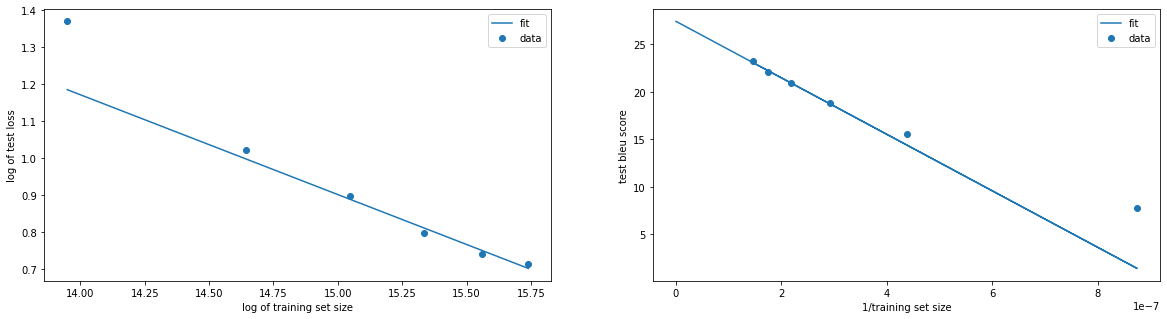

In [ ]:
def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(1, 2, figsize=(20,5))

logsize = np.log(sizes)
logloss = np.log(test_losses)
fit_params, _ = curve_fit(linear_fn, logsize[2:], logloss[2:])
print(fit_params)

loss_fitted_data = linear_fn(logsize, fit_params[0], fit_params[1])
ax[0].scatter(logsize, logloss, label='data')
ax[0].plot(logsize, loss_fitted_data, label='fit')
ax[0].set_xlabel('log of training set size')
ax[0].set_ylabel('log of test loss')
ax[0].legend()

oneoversizes = np.reciprocal(np.array(sizes, dtype=float))
fit_params, _ =curve_fit(linear_fn, oneoversizes[2:], test_bleus[2:])
print(fit_params)
bleu_fitted_data = linear_fn(np.insert(oneoversizes, 0, 0, 0), fit_params[0], fit_params[1])

ax[1].plot(np.insert(oneoversizes, 0, 0, 0), bleu_fitted_data, label='fit')
ax[1].scatter(np.reciprocal(np.array(sizes, dtype=float)), test_bleus,  label='data')
ax[1].set_xlabel('1/training set size')
ax[1].set_ylabel('test bleu score')
ax[1].legend()
plt.show()

Training set size in the above plots are defined as the number of tokens in the English sentences in the training set. The fits above are from the last four data points. From the first plot above, the test loss and the training set size kind of follow a power law. And from the second plot, the BLEU score seems to improve as a linear function of 1/train_set_size, and approaches 27.4 as the training set size goes to infinity. But of course I only have six data points from the range of 50k training examples to 300k training examples, it is hard to say what would happen if I use a much larger training set, and the fits above are not perfect. 